# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

#from nltk.corpus import stopwords as nltk_stopwords
#from sklearn.feature_extraction.text import TfidfVectorizer 
#import spacy
import re 
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, roc_curve,roc_auc_score


import transformers
import torch

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pprint
from tqdm.auto import tqdm
# const random_state 
RANDOM_STATE = 12345

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

In [4]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [6]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
35445,tt0062551,tvSeries,The Champions,The Champions,1968,1969,60,0,"Adventure,Sci-Fi,Thriller",7.5,927,My siblings and I stumbled upon The Champions ...,7,pos,1,train,11054
19485,tt0785016,movie,Kill Kill Faster Faster,Kill Kill Faster Faster,2008,\N,97,0,Thriller,4.3,652,I started to watch this movie expecting nothin...,10,pos,1,train,5320
40460,tt0117283,movie,The Pallbearer,The Pallbearer,1996,\N,98,0,"Comedy,Romance",4.9,7601,... You can't exactly shove her out of the way...,2,neg,0,train,7241
36402,tt0085461,movie,The Dresser,The Dresser,1983,\N,118,0,Drama,7.6,4637,A tough sell: British playwright Ronald Harwoo...,3,neg,0,test,6
23215,tt0066932,tvEpisode,Murder by the Book,Murder by the Book,1971,\N,76,0,"Crime,Drama,Mystery",7.7,3360,The story for the first-aired television insta...,8,pos,1,train,3460
37796,tt0171363,movie,The Haunting,The Haunting,1999,\N,113,0,"Fantasy,Horror,Mystery",5.0,69709,"What can I say that hasn't been said about ""Th...",8,pos,1,train,10648
72,tt0499603,movie,10 Items or Less,10 Items or Less,2006,\N,82,0,"Comedy,Drama",6.6,14062,Morgan Freeman and Paz Vega are the mismatched...,10,pos,1,train,4961
46205,tt0174336,movie,Whipped,Whipped,2000,\N,82,0,"Comedy,Romance",4.6,3881,I see quite a few positive reviews on this boa...,3,neg,0,train,1635
40017,tt0444736,movie,The Naked Brothers Band: The Movie,The Naked Brothers Band: The Movie,2005,\N,90,0,"Comedy,Family,Music",3.8,1103,I mean seriously what group would sing about a...,1,neg,0,train,4698
21709,tt0095593,movie,Married to the Mob,Married to the Mob,1988,\N,104,0,"Comedy,Crime,Romance",6.2,15647,Strange but acceptable mob comedy that has an ...,8,pos,1,test,5534


## EDA

Let's check the number of movies and reviews over years.

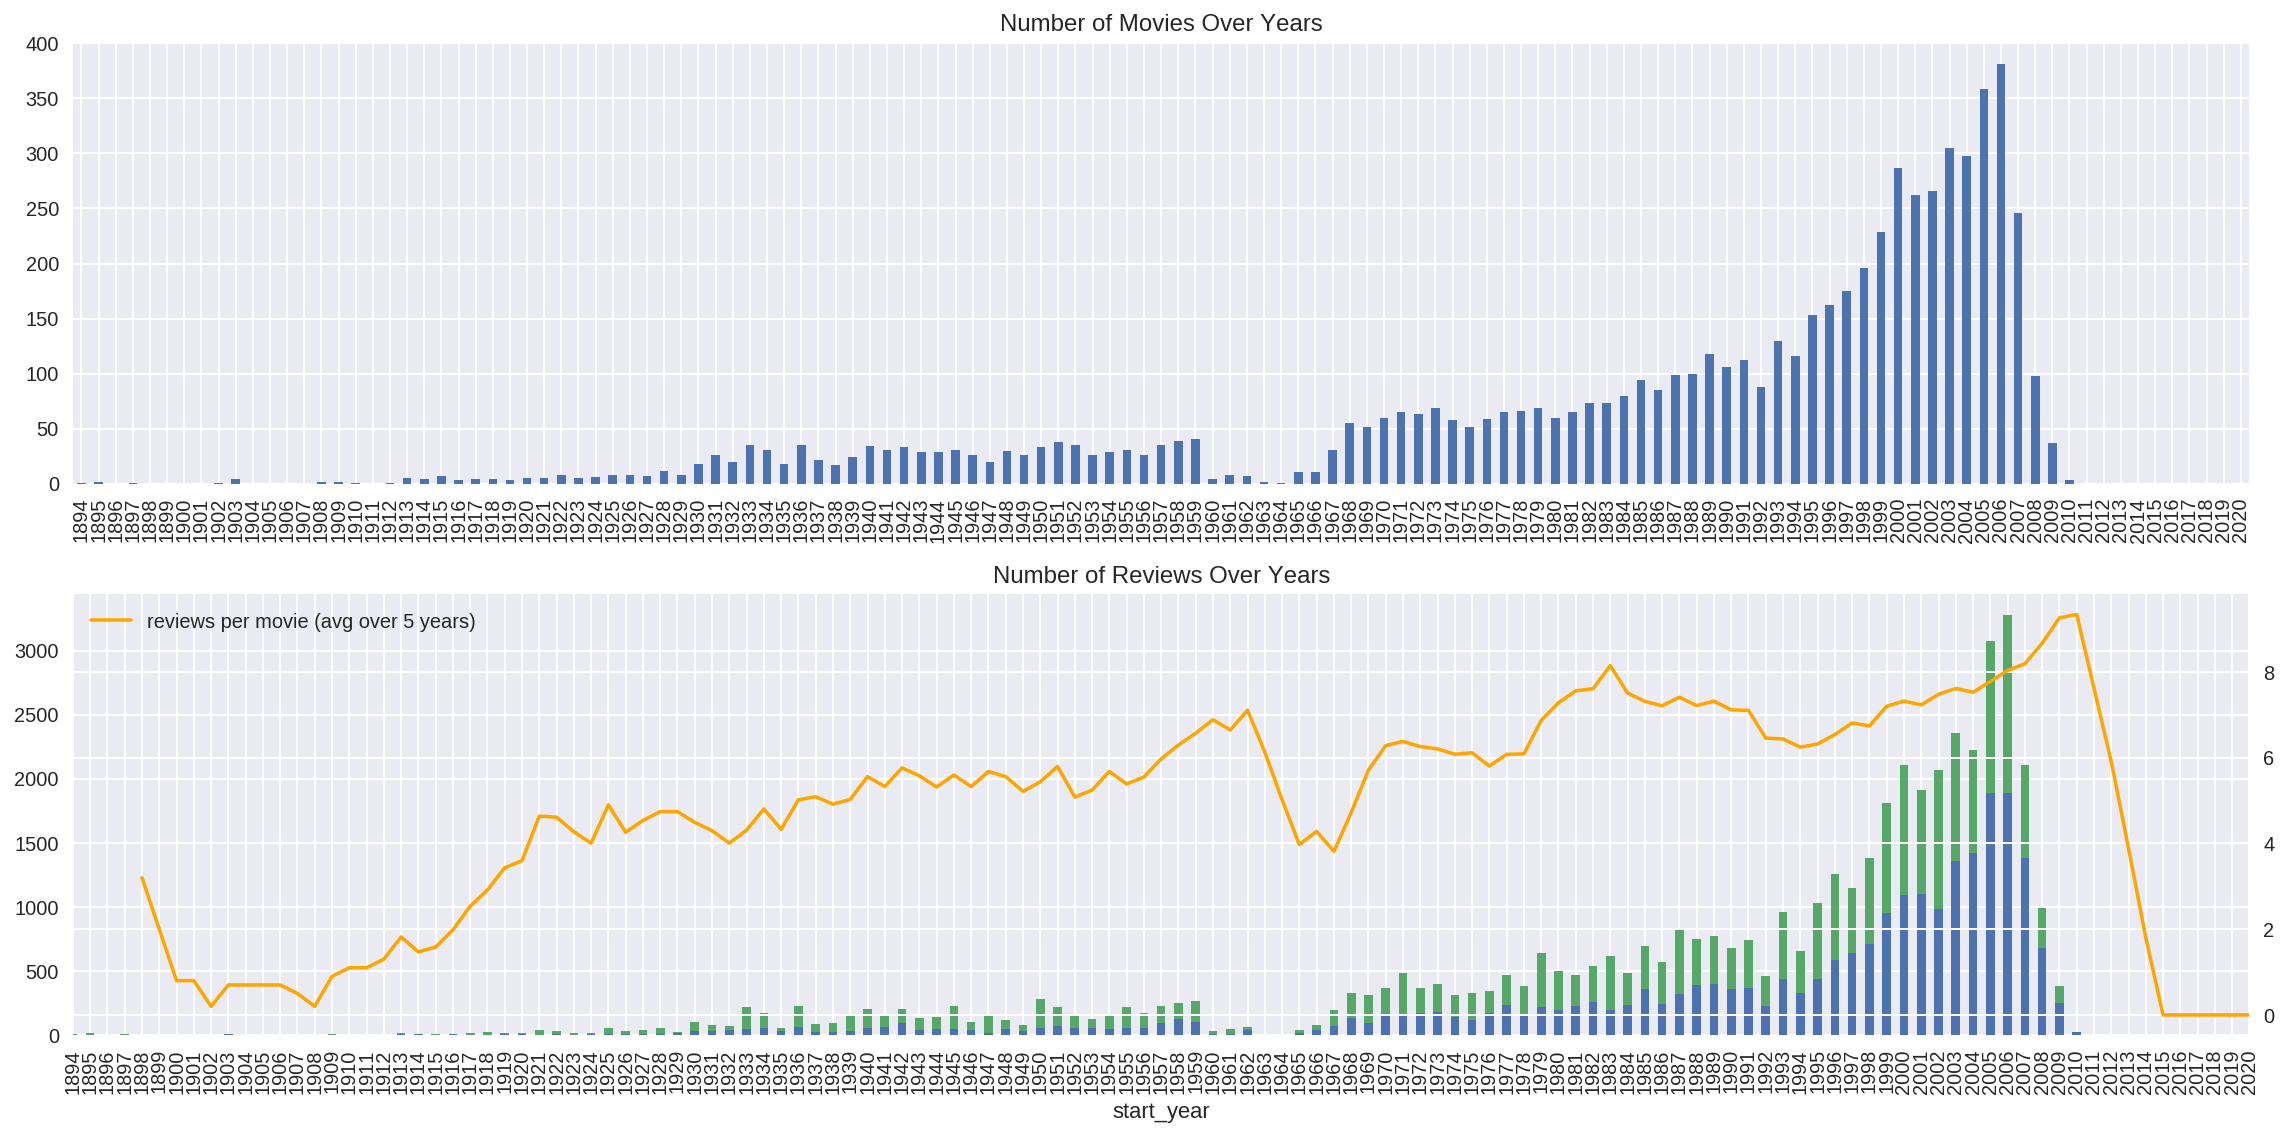

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

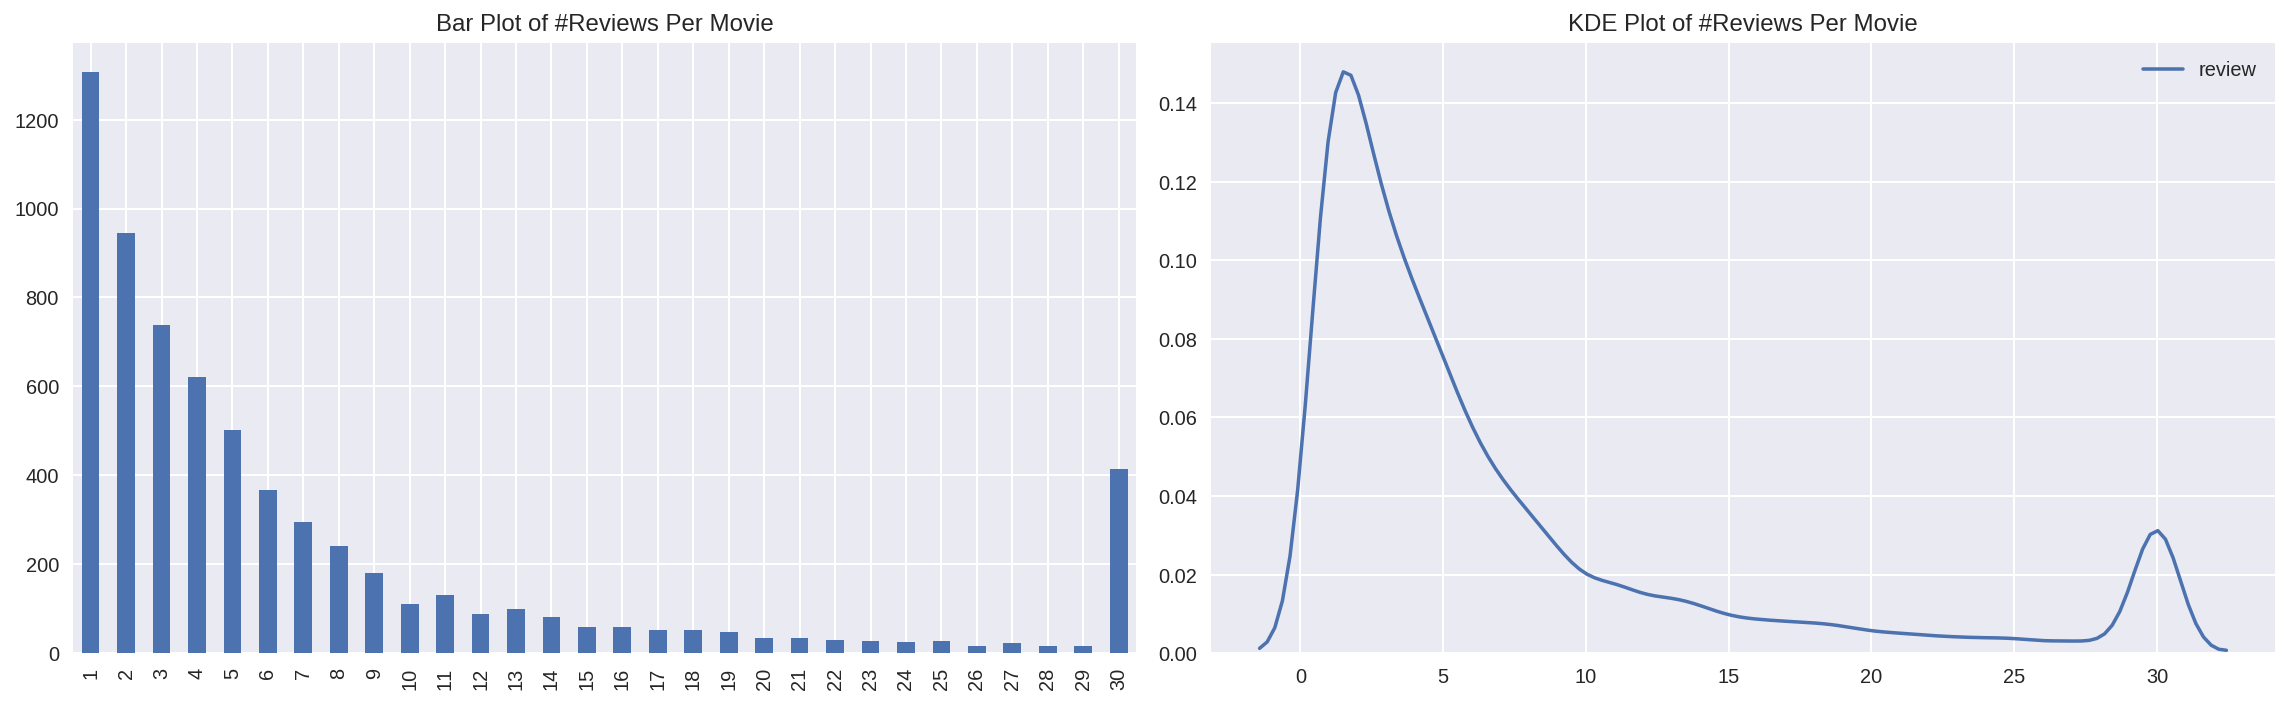

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

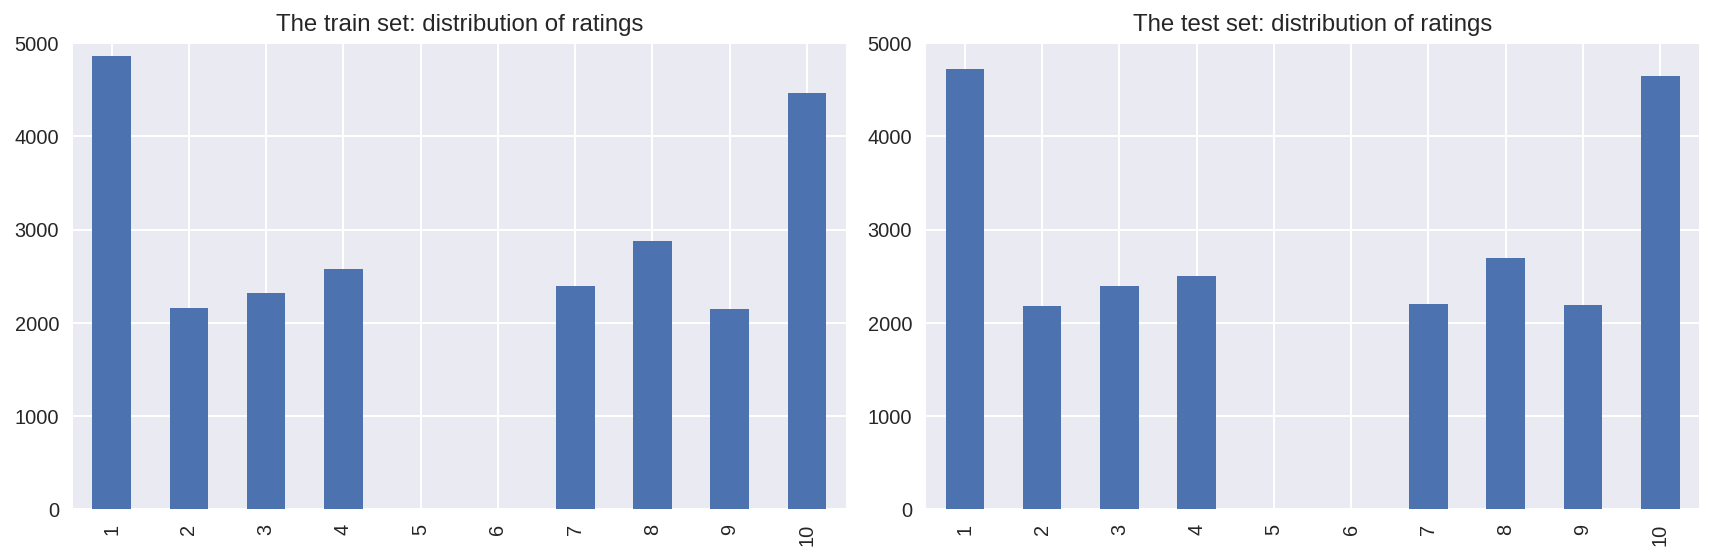

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

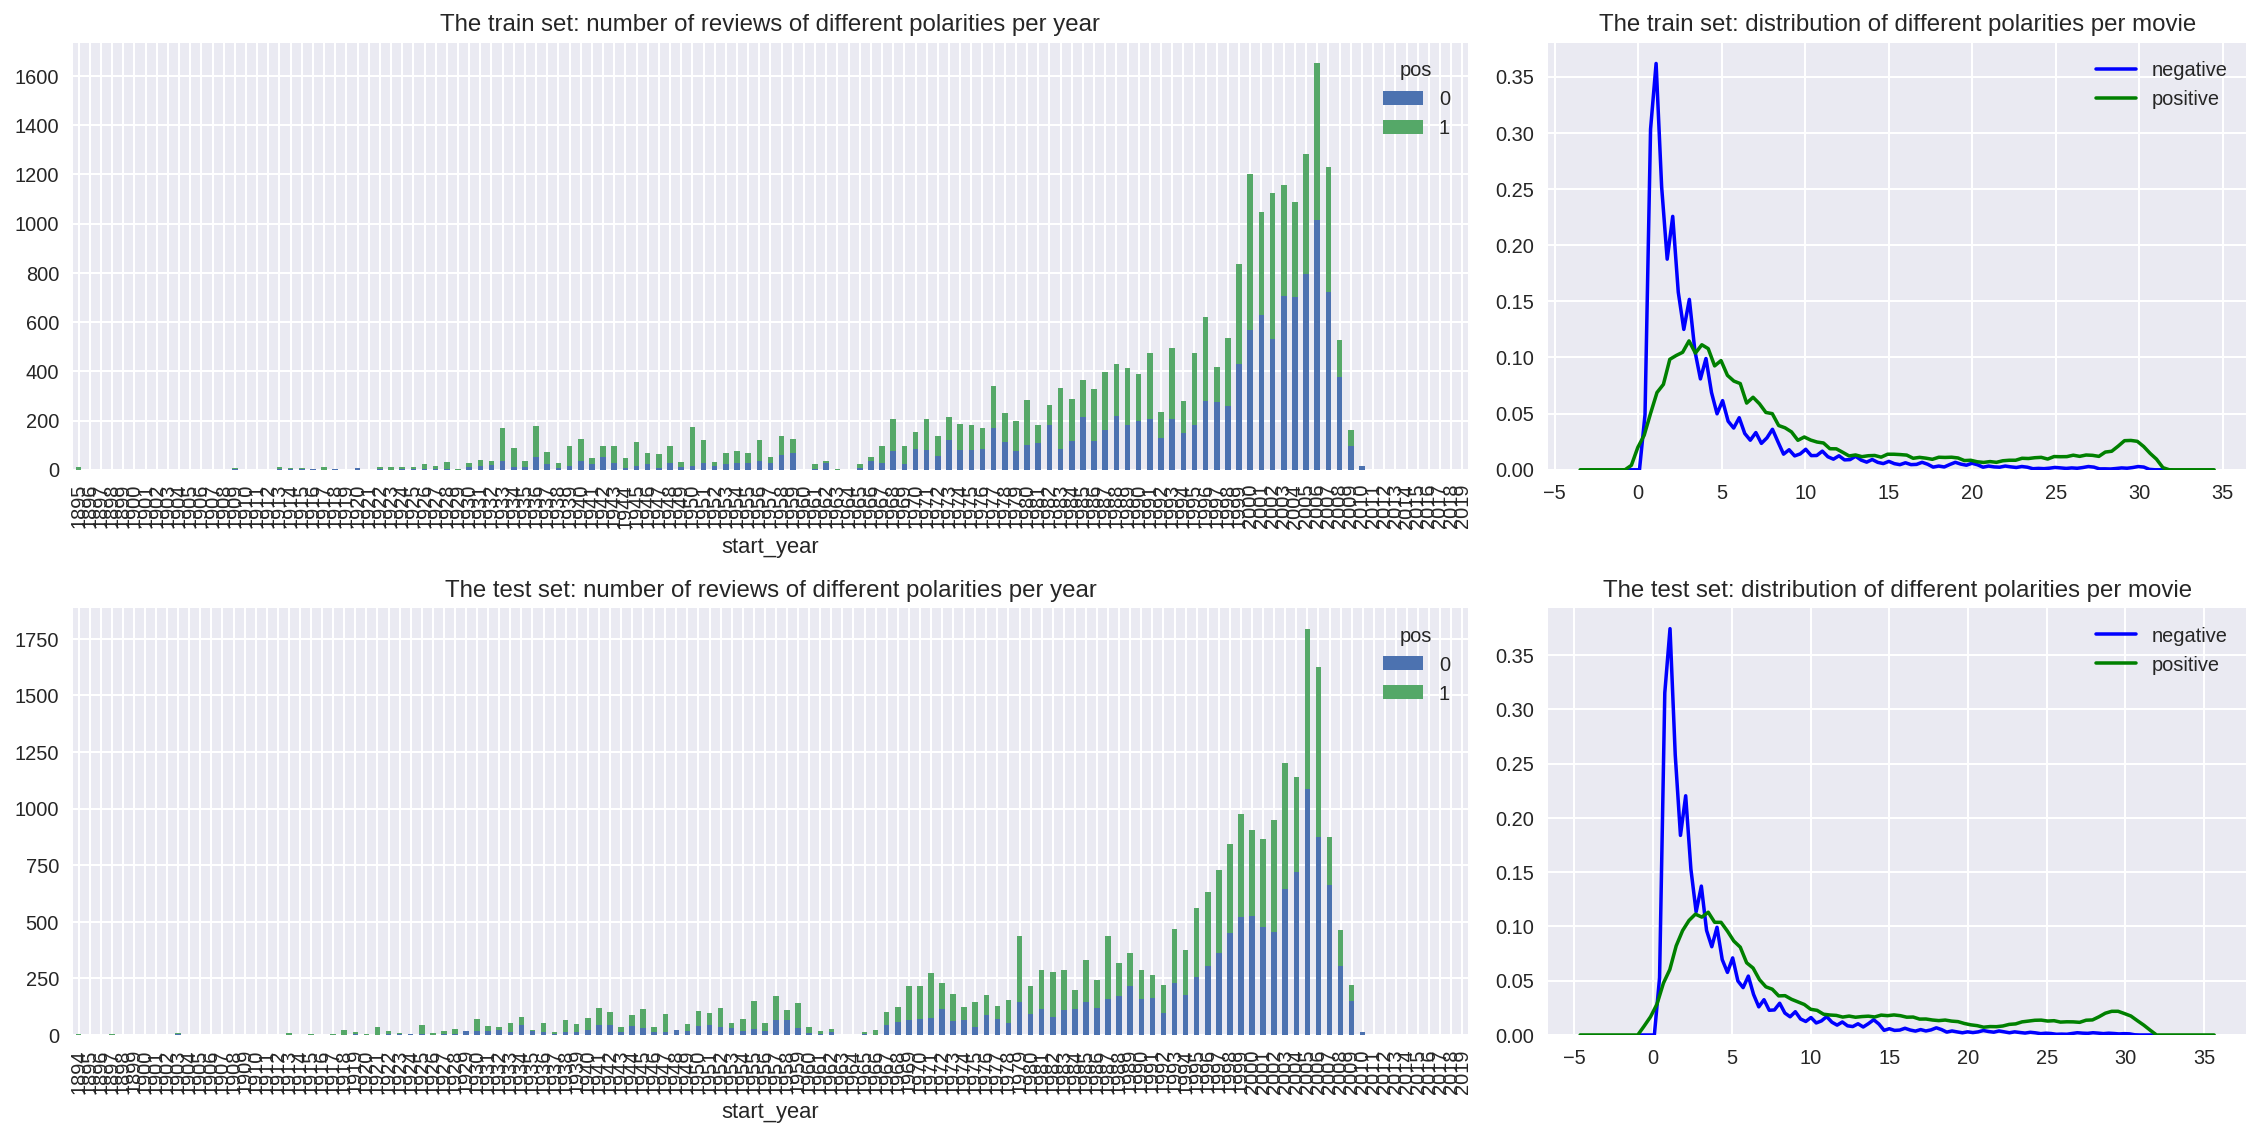

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Conclusion
According to the findings, we can say that we have a balanced class

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    model.fit(train_features,train_target)
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
pd.options.display.max_colwidth = 200 

In [14]:
# Texts in lowercase and without any digits, punctuations marks etc
def text_preprocessing_normalize(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = " ".join(text.split()).lower()
       
    return text

In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(text_preprocessing_normalize)
df_reviews['review_norm']

0        the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character withou...
1        how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks dr...
2        there is no real story the film seems more like a fly on the wall drama documentary than a proper film so this piece may in itself be a spoiler teen drama about young singaporean kids very similar...
3        um a serious film about troubled teens in singapore a country i have not much knowledge on but have the previous wrong impression that all the kids there are highly disciplined and controlled by t...
4        i'm totally agree with garryjohal from singapore's comments about this film quotation 'yes non singaporean's can't see what's the big deal about this film 

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

strategy=stratified
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5
strategy=most_frequent


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
strategy=prior


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
strategy=uniform


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5
strategy=constant
          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


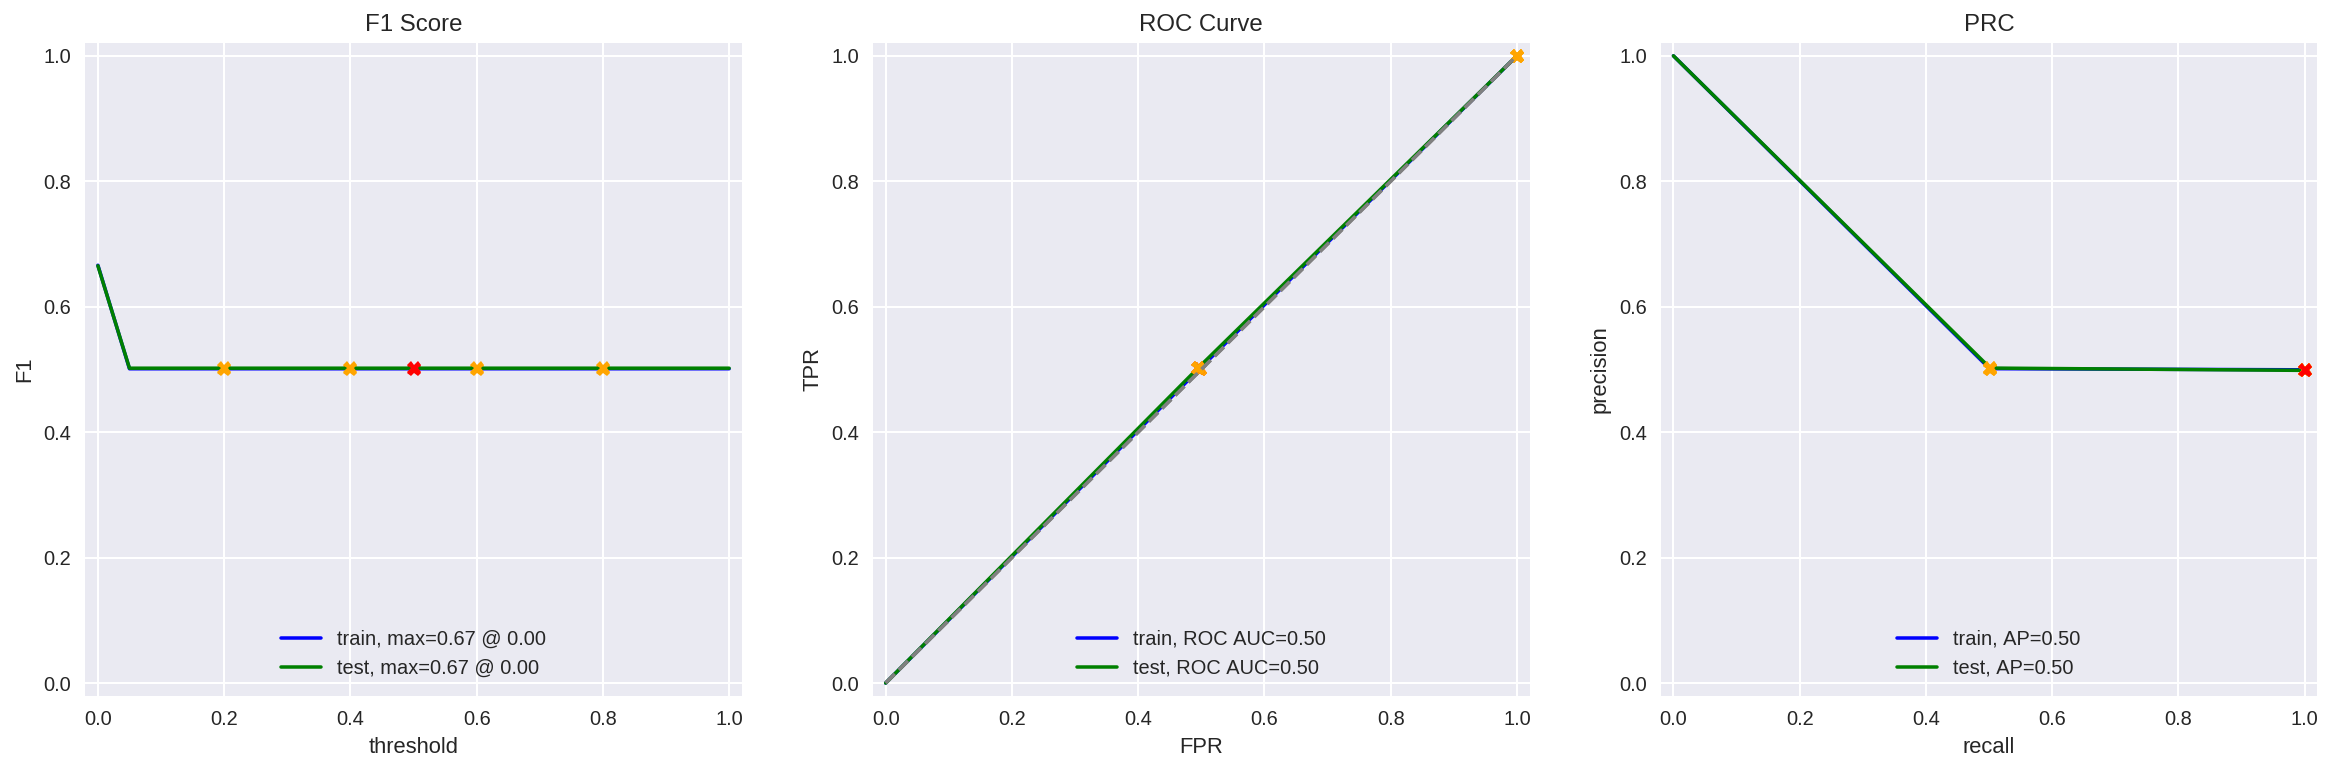

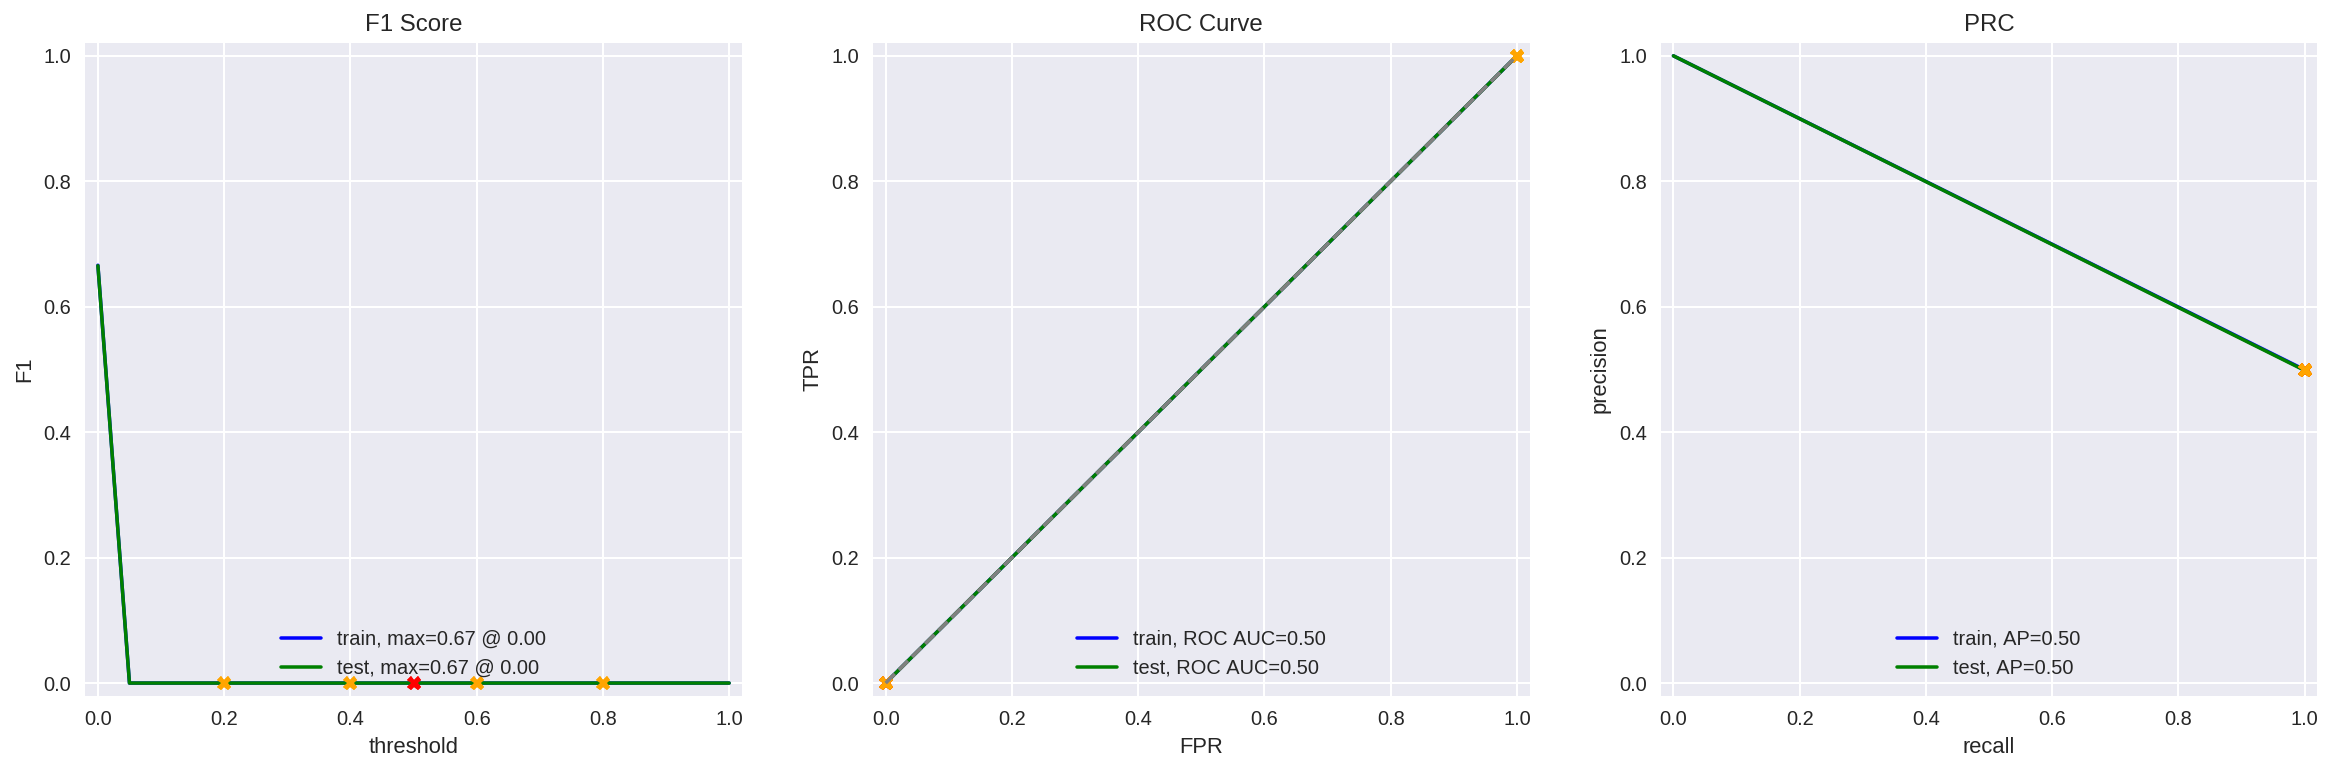

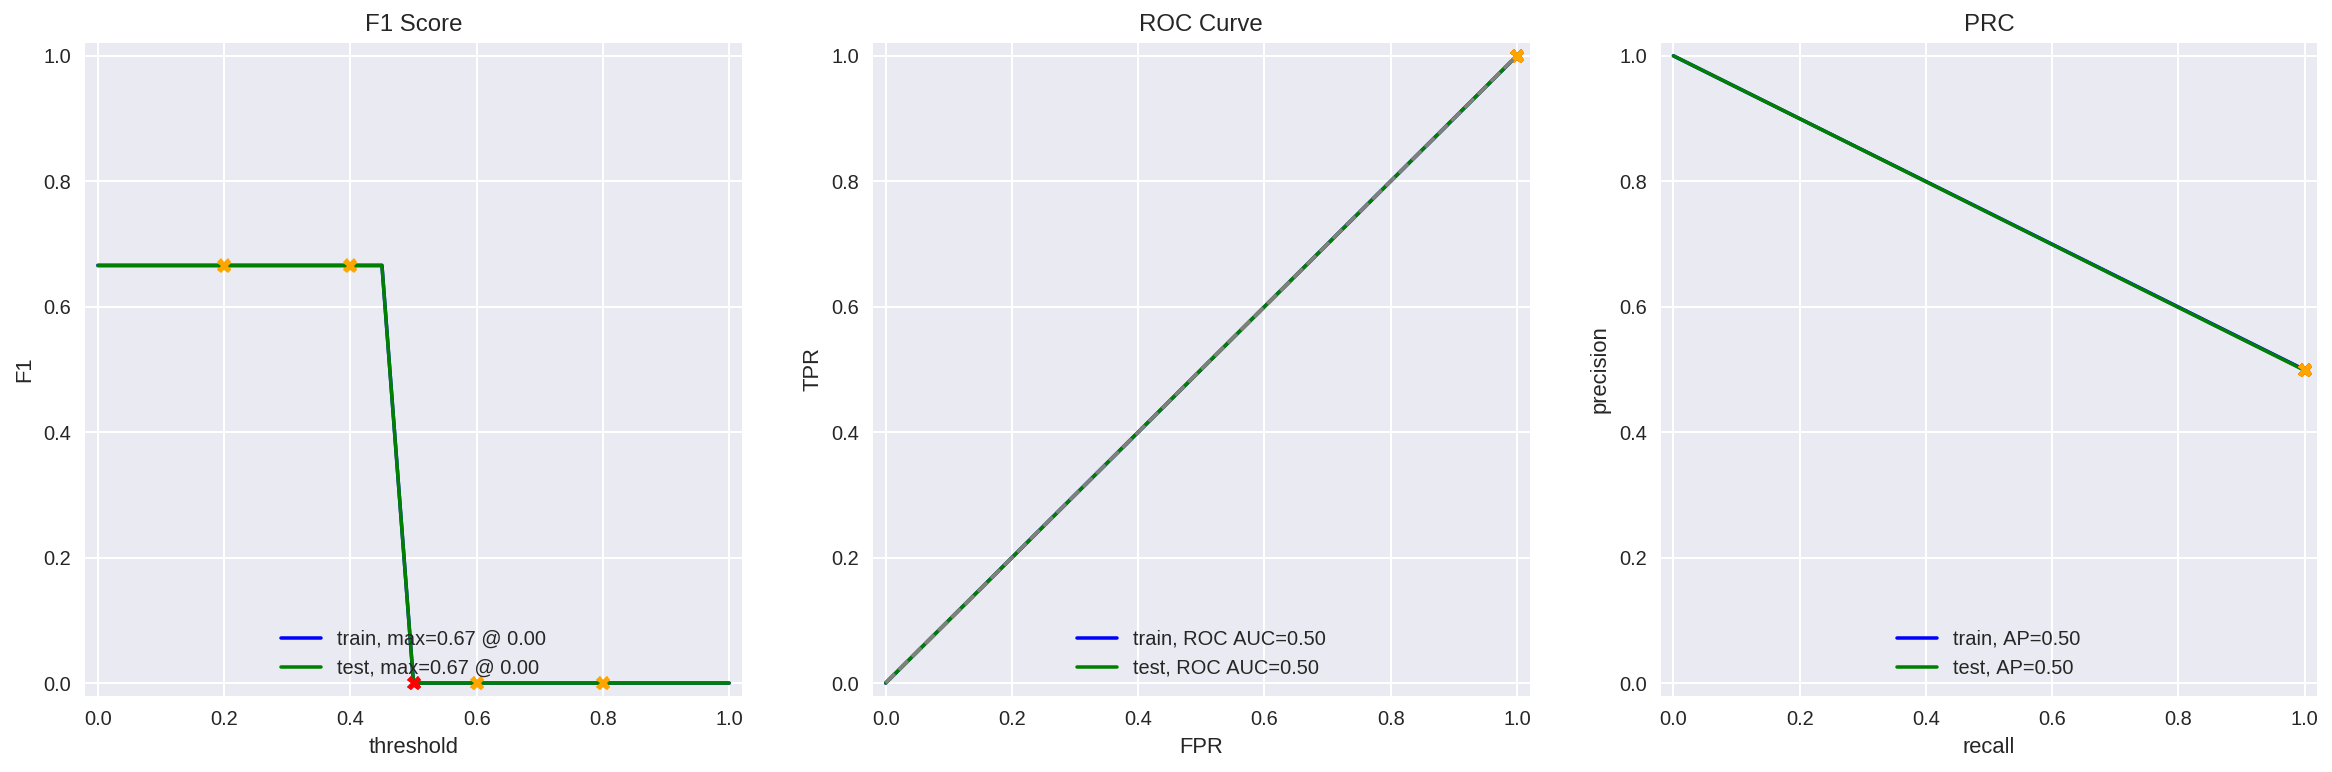

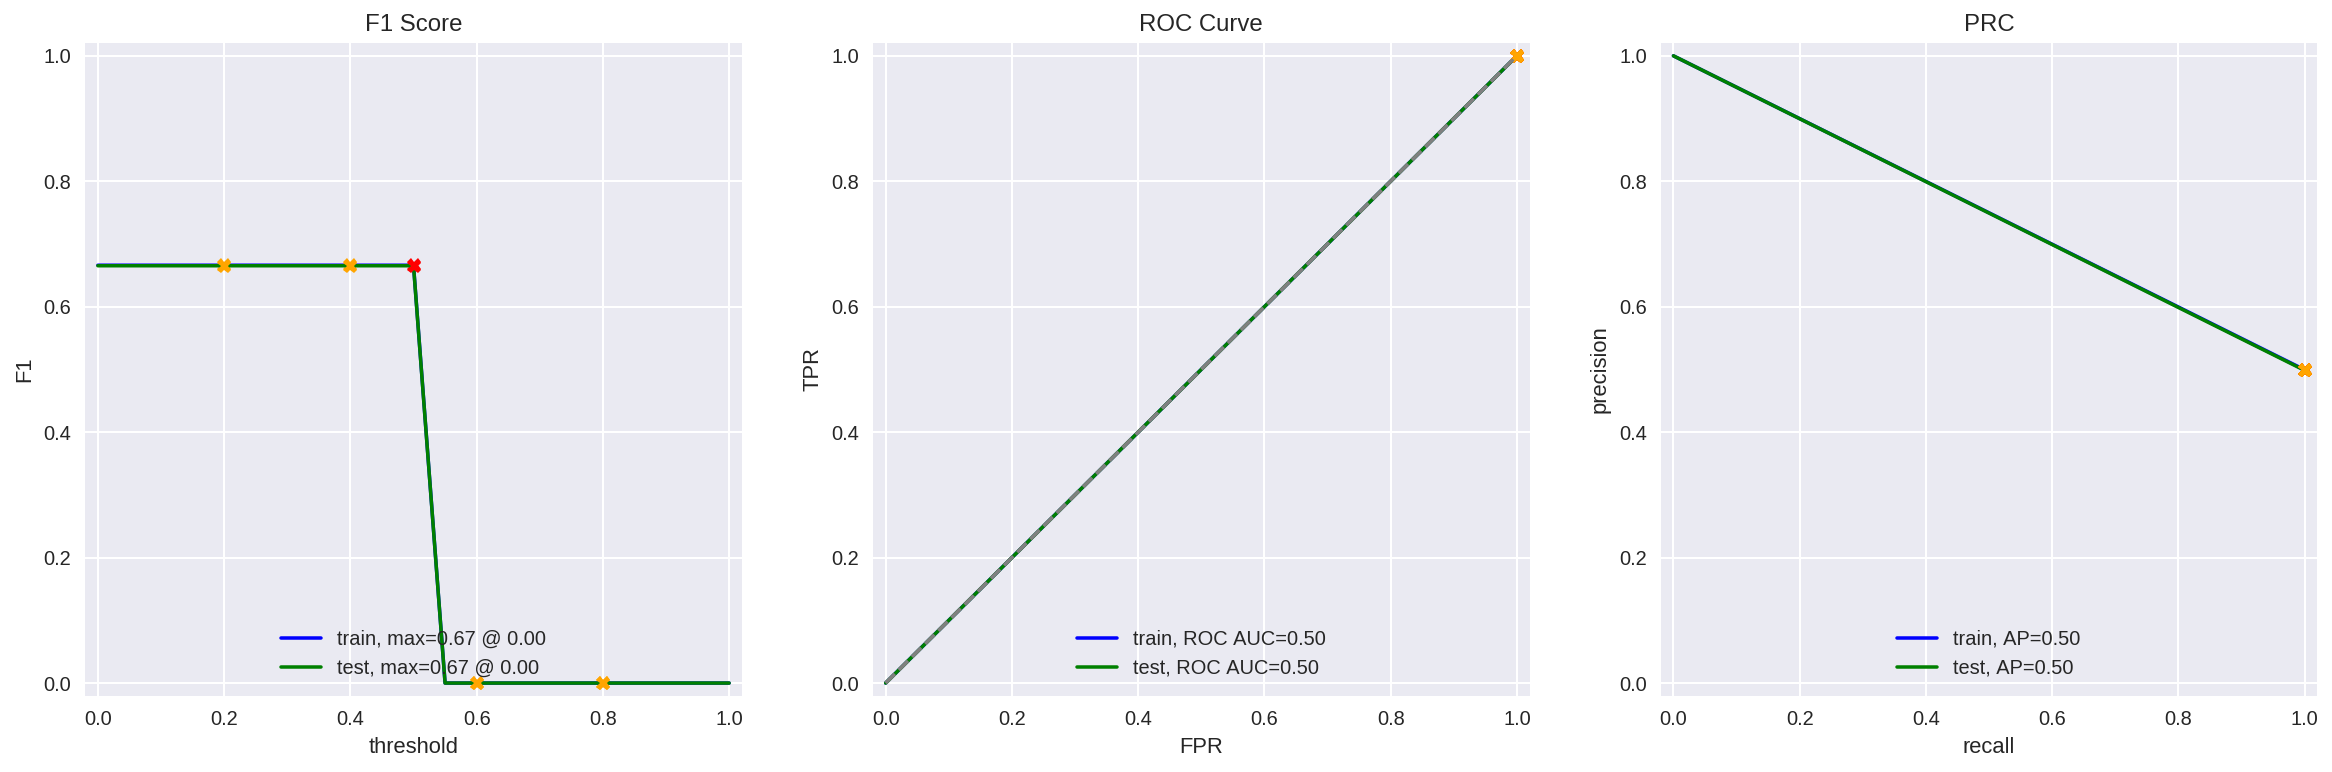

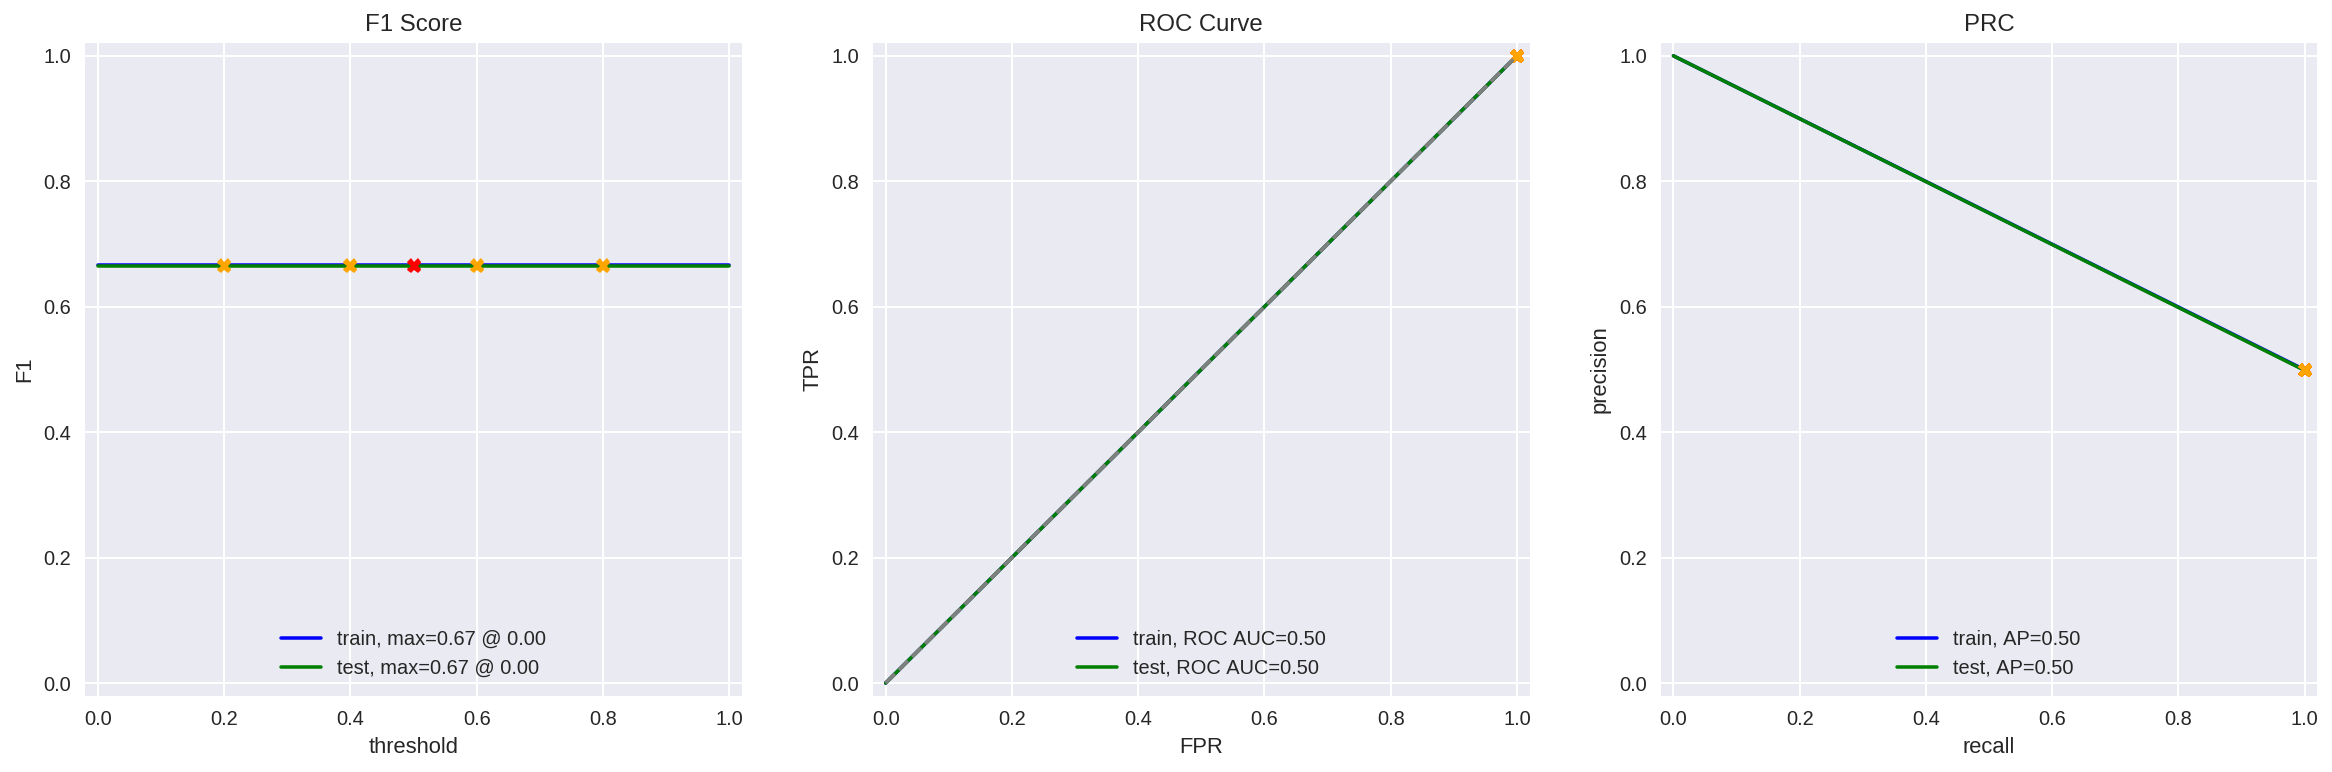

In [18]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

# List of strategy's to test dummy model
strategy_list=['stratified', 'most_frequent', 'prior', 'uniform','constant']

for strategy in strategy_list:  
    if strategy== 'constant':
         dummy_model = DummyClassifier(strategy=strategy, constant=1)
    else:
         dummy_model = DummyClassifier(strategy=strategy)
    
    print(f'strategy={strategy}')     
    evaluate_model(dummy_model, train_features, train_target, test_features, test_target)
    

constant strategy gave us the best F1 score of:   
train=0.67     
test=0.67 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
lemmatizer  = WordNetLemmatizer() 

In [20]:
def text_preprocessing_nltk(text):    
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    
    return ' '.join(tokens)

In [21]:
train_features = df_reviews_train['review_norm'].apply(text_preprocessing_nltk)
test_features = df_reviews_test['review_norm'].apply(text_preprocessing_nltk)

stop_words = set(nltk_stopwords.words('english'))
tf_idf_nltk = TfidfVectorizer(stop_words=stop_words) 

tf_idf_train = tf_idf_nltk.fit_transform(train_features) 
tf_idf_test  = tf_idf_nltk.transform(test_features) 

clf = LogisticRegression(random_state=RANDOM_STATE)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


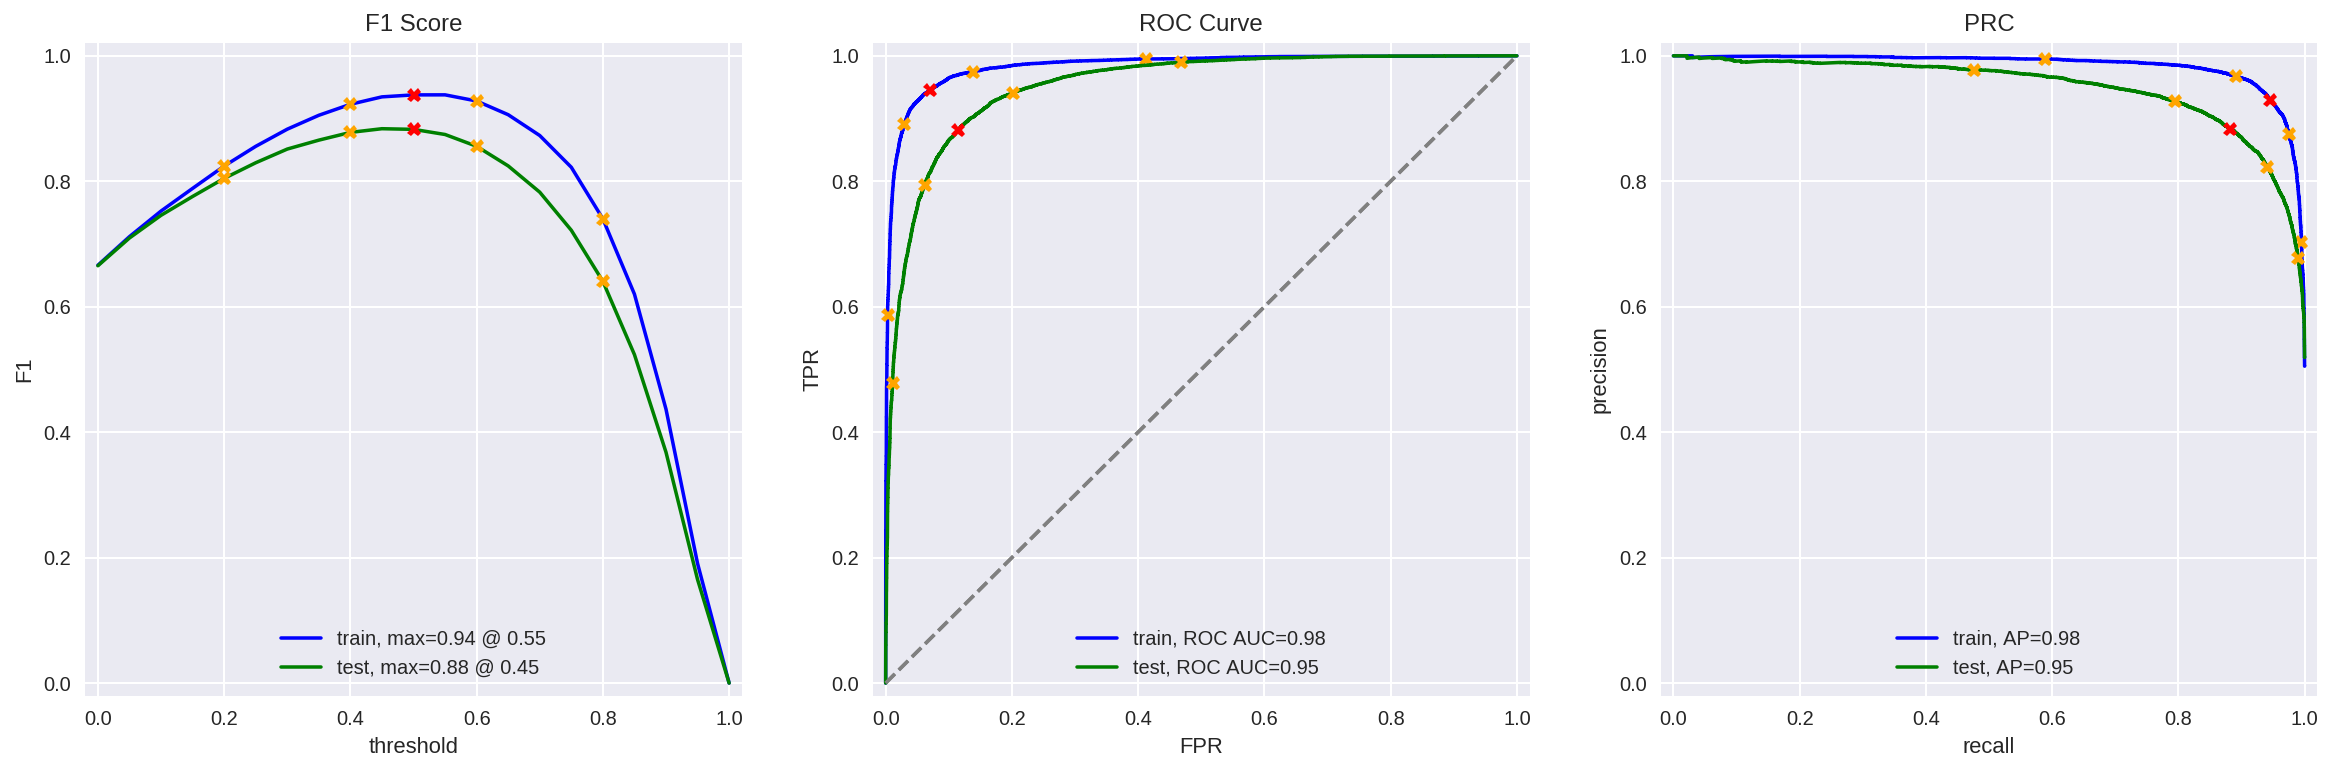

In [22]:
evaluate_model(clf, tf_idf_train, train_target, tf_idf_test, test_target)

In [23]:
#evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
def text_preprocessing_spacy(text):    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [26]:
train_features = df_reviews_train['review_norm'].apply(text_preprocessing_spacy)
test_features = df_reviews_test['review_norm'].apply(text_preprocessing_spacy)

stop_words = set(nltk_stopwords.words('english'))
tf_idf_spacy = TfidfVectorizer(stop_words=stop_words) 

tf_idf_train = tf_idf_spacy.fit_transform(train_features) 
tf_idf_test  = tf_idf_spacy.transform(test_features) 

model_lr = LogisticRegression(random_state=RANDOM_STATE)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


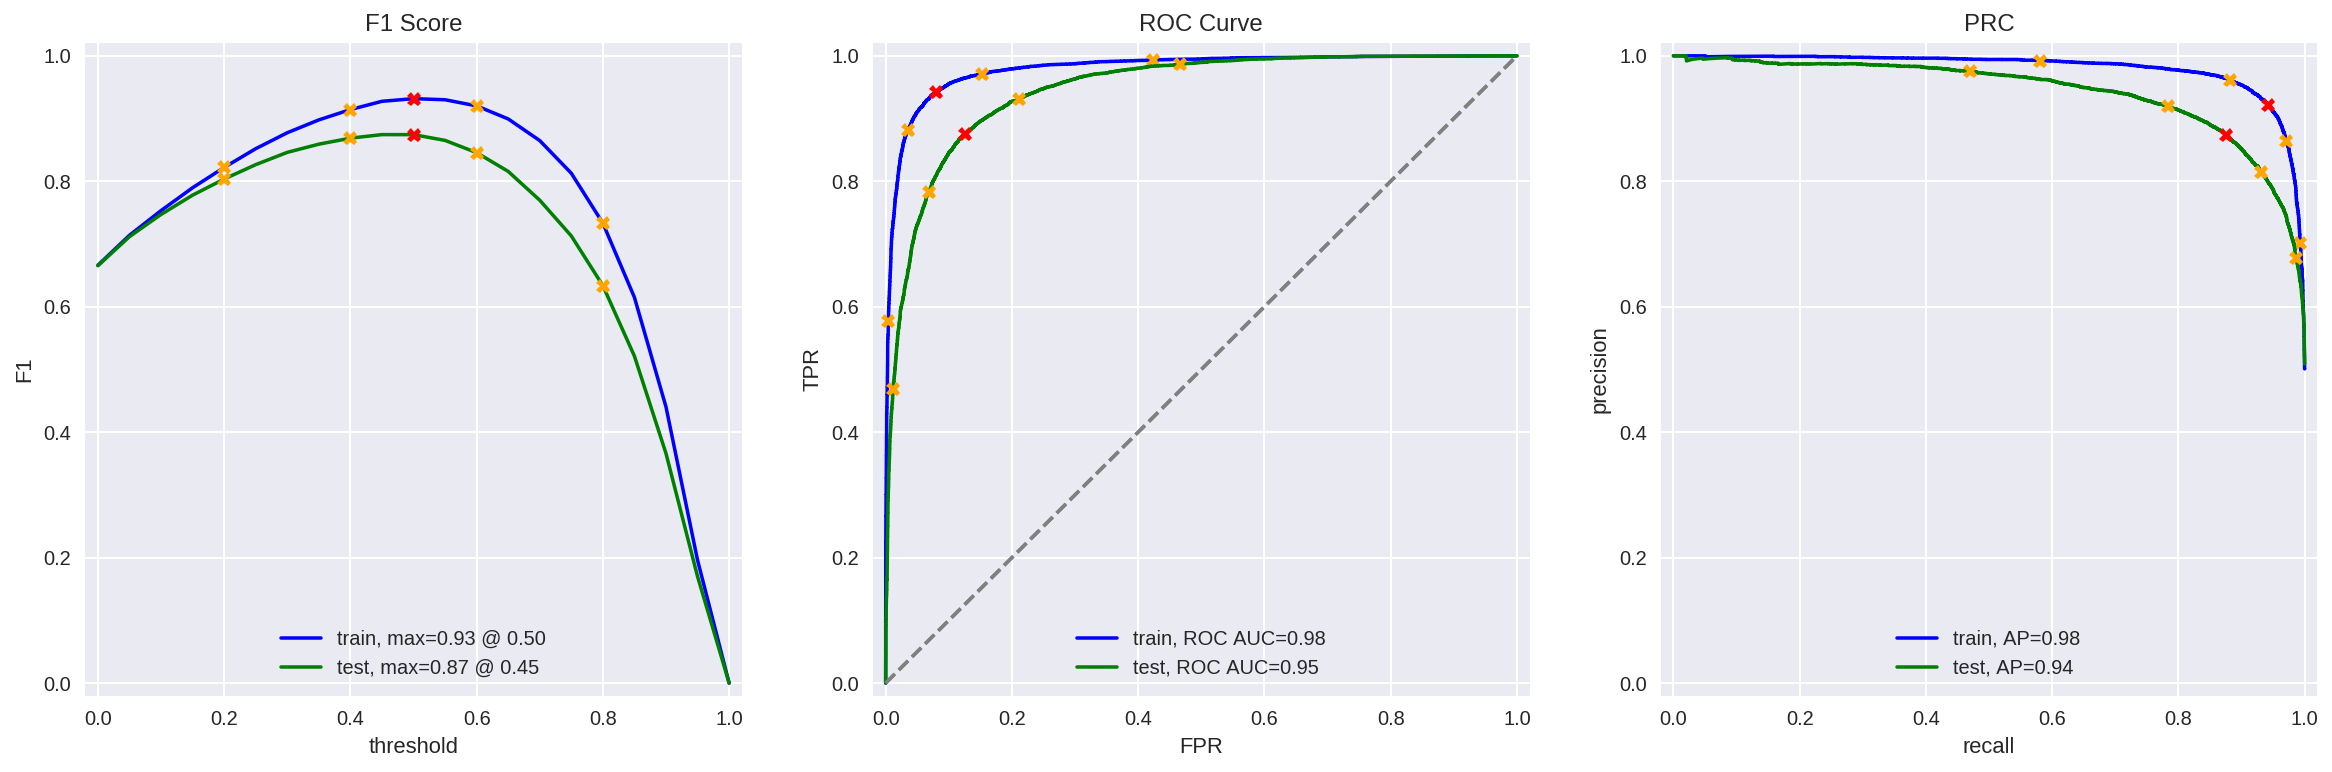

In [27]:
evaluate_model(model_lr, tf_idf_train, train_target, tf_idf_test, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [28]:
from lightgbm import LGBMClassifier 
from sklearn.model_selection import GridSearchCV

In [29]:
# take only sample of data, so it will not take long run on CPU
df_reviews_train_sample = df_reviews_train.sample(1000)
df_reviews_test_sample = df_reviews_test.sample(1000)

train_features_sample = df_reviews_train_sample['review_norm'].apply(text_preprocessing_spacy)
test_features_sample =  df_reviews_test_sample['review_norm'].apply(text_preprocessing_spacy)

train_target_sample = df_reviews_train_sample['pos']
test_target_sample = df_reviews_test_sample['pos']

tf_idf_spacy_lgbm = TfidfVectorizer(stop_words=stop_words) 

tf_idf_train_sample = tf_idf_spacy_lgbm.fit_transform(train_features_sample) 
tf_idf_test_sample  = tf_idf_spacy_lgbm.transform(test_features_sample) 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.82  0.72
F1         0.83  0.75
APS        0.91  0.78
ROC AUC    0.91  0.79
CPU times: user 20.8 s, sys: 170 ms, total: 21 s
Wall time: 21.1 s


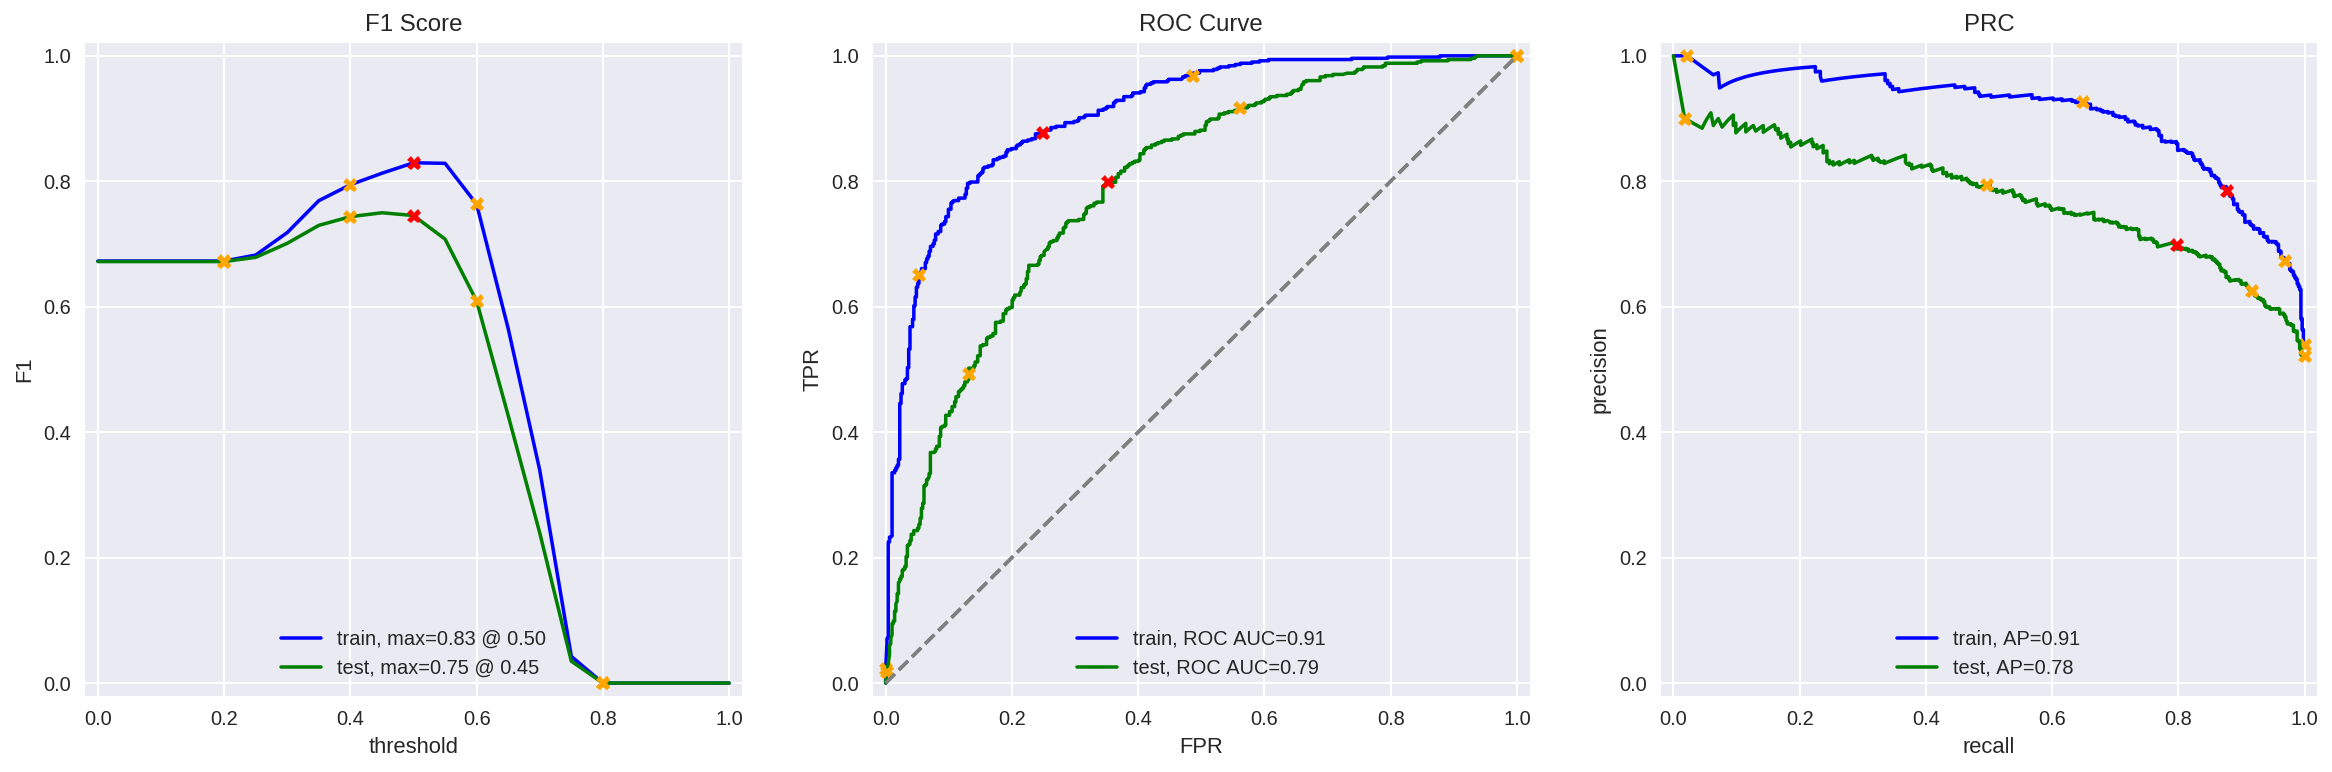

In [30]:
%%time
model_lgbm = LGBMClassifier()
params = {
    'n_estimators': range(10, 25, 25),
    'colsample_bytree': np.arange(0.1, 0.9,0.5),
    'max_depth': range(10, 25, 25),
    'num_leaves': range(50, 200, 150),
    'reg_alpha': np.arange(1.1, 1.5, 0.4),
    'reg_lambda': np.arange(1.1, 1.3, 0.2),
    'min_split_gain': np.arange(0.3, 0.4,0.1),
    'subsample': np.arange(0.7, 0.9, 0.2),
    'subsample_freq': [20]
}
grid = GridSearchCV(model_lgbm, param_grid = params, cv=5)

evaluate_model(grid, tf_idf_train_sample, train_target_sample, tf_idf_test_sample, test_target_sample)

For different samples there are different results

###  Model 9 - BERT

In [31]:
import torch
import transformers

In [32]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [33]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      
    
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
      
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
   
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [34]:
%%time
# take only sample of data, so it will not take long run on CPU
df_reviews_train_sample = df_reviews_train.sample(50)
df_reviews_test_sample = df_reviews_test.sample(50)


train_features_sample = df_reviews_train_sample['review_norm']
test_features_sample = df_reviews_test_sample['review_norm']

train_target_sample  = df_reviews_train_sample['pos']
test_target_sample = df_reviews_test_sample['pos']

# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
train_features_sample_embeddings = BERT_text_to_embeddings(train_features_sample)
test_features_sample_embeddings = BERT_text_to_embeddings(test_features_sample)

Using the cpu device.



Using the cpu device.



CPU times: user 6min 2s, sys: 1min 27s, total: 7min 29s
Wall time: 7min 30s


In [35]:
print(df_reviews_train['review_norm'].shape)
print(train_features_sample_embeddings.shape)
print(train_target_sample.shape)

(23796,)
(50, 768)
(50,)


In [36]:
print(test_features_sample_embeddings.shape)
print(test_target_sample.shape)

(50, 768)
(50,)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    1.0  0.70
F1          1.0  0.74
APS         1.0  0.81
ROC AUC     1.0  0.80


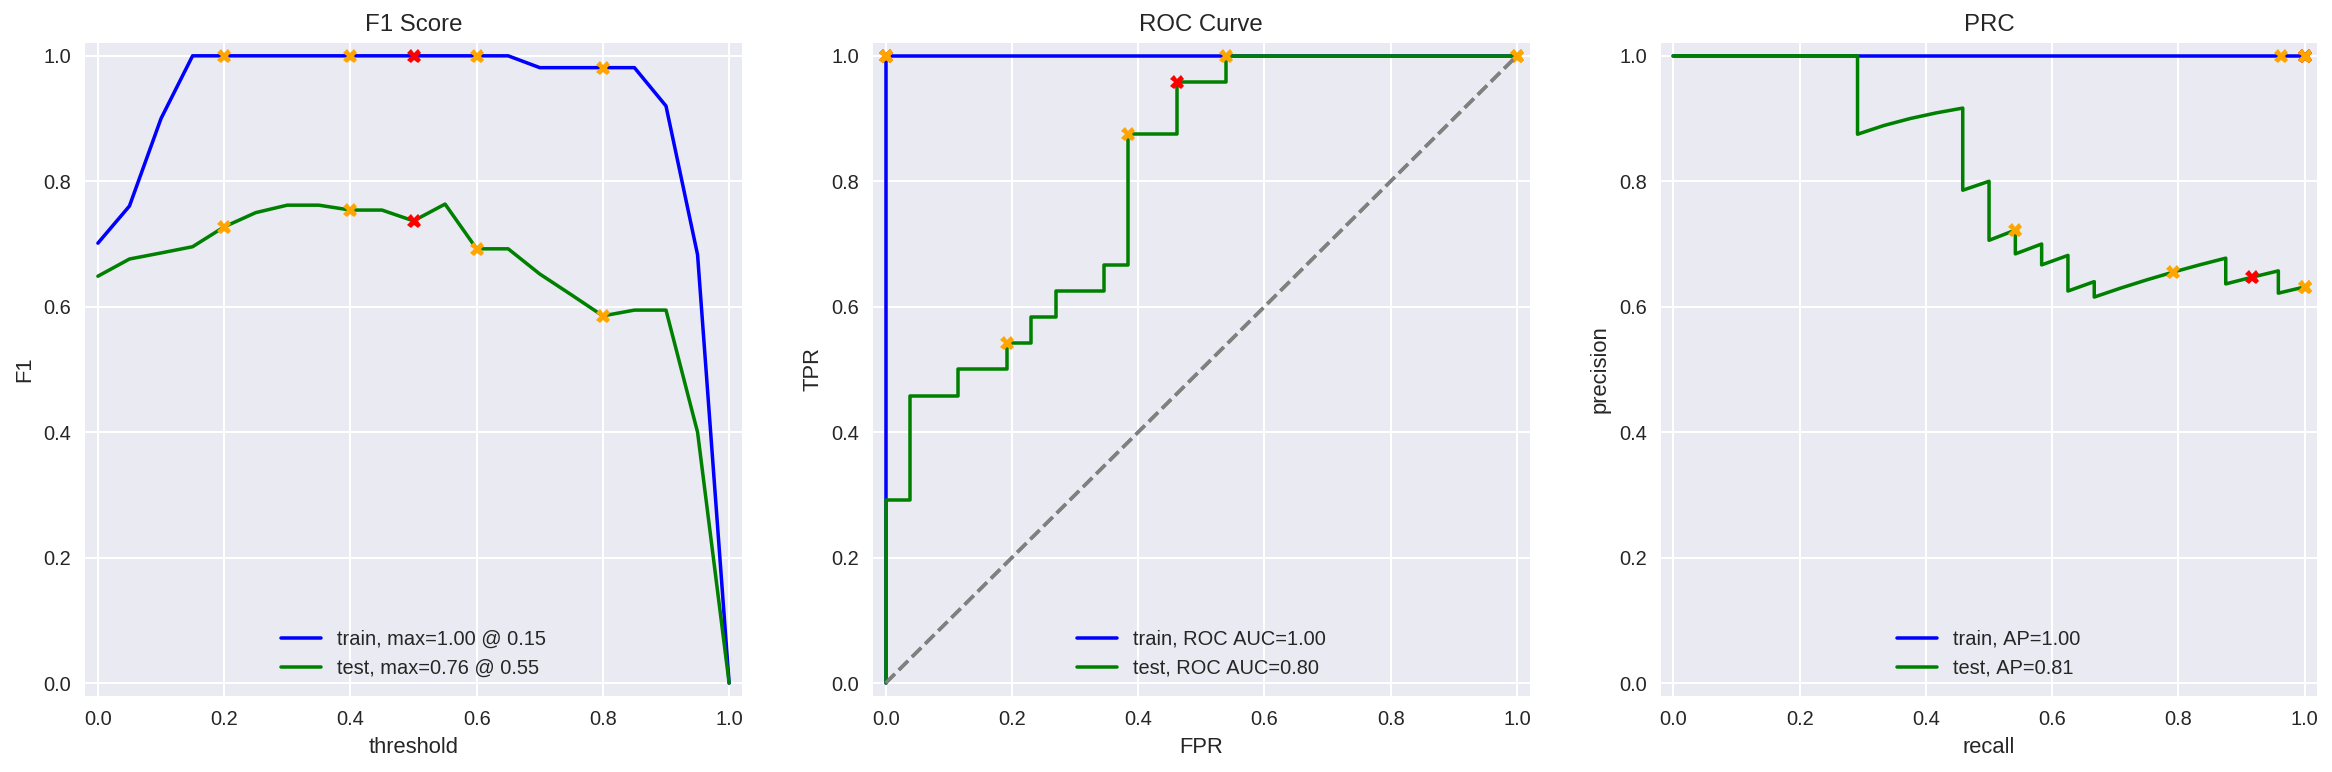

In [37]:
model_bert = LogisticRegression(random_state=RANDOM_STATE)
evaluate_model(model_bert, train_features_sample_embeddings, train_target_sample,\
               test_features_sample_embeddings, test_target_sample)

In [38]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [39]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_normalize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middle of the movie.",well i was bored and felt asleep in the middle of the movie
2,I was really fascinated with the movie,i was really fascinated with the movie
3,"Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
4,I didn't expect the reboot to be so good! Writers really cared about the source material,i didn't expect the reboot to be so good writers really cared about the source material
5,"The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
6,"What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
7,"Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.",launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


### Model 2

In [68]:
texts = my_reviews['review_norm'].apply(text_preprocessing_nltk)

my_reviews_pred_prob = clf.predict_proba(tf_idf_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print(f'mean= {my_reviews_pred_prob.mean():.2f}')   

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i did n't expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it 's a decent flick i could see mys
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
mean= 0.32


### Model 3

In [65]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr.predict_proba(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print(f'mean= {my_reviews_pred_prob.mean():.2f}')   

0.16:  i did not simply like it not my kind of movie
0.05:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.23:  i didn't expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
mean= 0.30


### Model 4

In [64]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tf_idf_spacy
my_reviews_pred_prob = grid.predict_proba(tf_idf_spacy_lgbm.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print(f'mean= {my_reviews_pred_prob.mean():.2f}')   

0.55:  i did not simply like it not my kind of movie
0.55:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.45:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.52:  i didn't expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.52:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.55:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
mean= 0.53


### Model 9

In [63]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_bert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print(f'mean= {my_reviews_pred_prob.mean():.2f}')   

0.04:  i did not simply like it not my kind of movie
0.03:  well i was bored and felt asleep in the middle of the movie
0.16:  i was really fascinated with the movie
0.02:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.06:  i didn't expect the reboot to be so good writers really cared about the source material
0.66:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
mean= 0.24247621742295822


## Conclusions

In [59]:
#Get results
data=[['BERT',1.0,0.74],
      ['LGBM',0.83,0.75],
      ['spacy LR',0.93,0.87],
      ['NLTK LR',0.94,0.88],
      ['Dummy',0.67,0.67]
]

 
columns=['model','train','test']
results = pd.DataFrame(data,columns=columns)
print('f1 scores')
results

f1 scores


,model,train,test
0,BERT,1.00,0.74
1,LGBM,0.83,0.75
2,spacy LR,0.93,0.87
3,NLTK LR,0.94,0.88
4,Dummy,0.67,0.67


- using LR and NLTK  gave us the best results for the train and test 
- LR using spacy and NLTK gave us results higher than 0.85 for the train and test
- All the models preform better than the dummy model
- For all models 2,3,9 in chapter 8 , only one review add a high probability more than 0.8.
  most of the probabilities had i lower probability.